# Flux analysis, homocysteine tracing

In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import norm
import sys

In [2]:
#  path to simpleflux package 
sys.path.append('C:/code/python/simpleflux/src')
from simpleflux.model import FluxModel, FluxState
from simpleflux.modelstate import ModelState
from simpleflux.fitting import ModelFit

In [107]:
input_data_path = Path('00_input_data')
heavy_fractions_path = Path('02_heavy_fractions')
results_path = Path('04_hcys_flux_analysis')

In [4]:
# make matplotlib use TrueType fonts for PDF export
matplotlib.rcParams['pdf.fonttype'] = 42

In [5]:
np.set_printoptions(precision=3, suppress=True)

## Define functions

In [6]:
def prepend_index_level(df: pd.DataFrame, values, name: str) -> pd.DataFrame:
    return df.assign(**{name: values}).set_index(name, append=True).swaplevel()

In [7]:
def plot_model_fit(flux_model: FluxModel, x_predicted: pd.DataFrame,
                   heavy_fractions: pd.DataFrame, use_log_scale: bool = False) -> None:
    y_axis_margin = 0.05
    fig, axs = plt.subplots(ncols=len(flux_model.metabolites), figsize=(15,3))
    for i, metabolite in enumerate(flux_model.metabolites):
        axs[i].plot(x_predicted[metabolite])
        if metabolite in heavy_fractions.columns:
            axs[i].plot(heavy_fractions[metabolite], '.')
        axs[i].set_ylim(-y_axis_margin, 1 + y_axis_margin)
        axs[i].set_title(metabolite)
        if use_log_scale:
            axs[i].set_xscale('log')
            axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[i].set_xticks(heavy_fractions.index)

In [48]:
def plot_file_name(cell_type: str, log_scale: bool) -> str:
    plot_name = 'hcys_fitted_data'
    if log_scale:
        scale_suffix = 'logscale'
    else:
        scale_suffix = 'linscale'
    return "_".join([cell_type, plot_name, scale_suffix]) + '.pdf'

In [9]:
def confidence_intervals_table(model_fit: ModelFit, ci_level: float) -> pd.DataFrame:
    fitted_net_fluxes = model_fit.model_state.flux_state.net_fluxes
    net_flux_std_err = model_fit.fitted_fluxes_std_err()
    ci_scale_factor = norm.isf((1 -ci_level)/2)
    return pd.DataFrame(
        {
            'net': fitted_net_fluxes,
            'std err': net_flux_std_err,
            'ci_half-width': net_flux_std_err*ci_scale_factor,
            'ci_lower': fitted_net_fluxes - net_flux_std_err*ci_scale_factor,
            'ci_upper': fitted_net_fluxes + net_flux_std_err*ci_scale_factor,
        },
        index=pd.Index(flux_model.reactions, name='reaction')
    )

## Define model

### Stoichiometry

In [10]:
stoichiometry = defaultdict(int, {
    ('HCYS_IN', 'hcys'): 1,
    ('PROT_SYNTH', 'met'): -1, ('PROT_SYNTH', 'metp'): 1, 
    ('AHCY', 'sah'): -1, ('AHCY', 'hcys'): 1, 
    ('METS', 'hcys'): -1, ('METS', 'met'): 1, 
    ('MAT', 'met'): -1, ('MAT', 'sam'): 1, 
    ('SAM_METH', 'sam'): -1, ('SAM_METH', 'sah'): 1, 
    ('CYSTS', 'hcys'): -1, ('CYSTS', 'cyst'): 1,
    ('CYSTL', 'cyst'): -1, ('CYSTL', 'akb'): 1,
    ('MET_OUT', 'met'): -1,
    ('PROT_OUT', 'metp'): -1,
    ('AKB_OUT', 'akb'): -1,
})

reversible_reactions = [
    'HCYS_IN',
    'PROT_SYNTH',
    'AHCY',
    'CYSTL',
]

free_reactions = ['CYSTS', 'METS', 'PROT_OUT', 'SAM_METH']

flux_model = FluxModel(stoichiometry, reversible_reactions, free_reactions)

In [11]:
flux_model.get_stoichiometry_df()

,AHCY,AKB_OUT,CYSTL,CYSTS,HCYS_IN,MAT,METS,MET_OUT,PROT_OUT,PROT_SYNTH,SAM_METH
akb,0,-1,1,0,0,0,0,0,0,0,0
cyst,0,0,-1,1,0,0,0,0,0,0,0
hcys,1,0,0,-1,1,0,-1,0,0,0,0
met,0,0,0,0,0,-1,1,-1,0,-1,0
metp,0,0,0,0,0,0,0,0,-1,1,0
sah,-1,0,0,0,0,0,0,0,0,0,1
sam,0,0,0,0,0,1,0,0,0,0,-1


## D4-homocysteine tracing

### Pool sizes

Estimated intracellular concentrations in uM

NOTE: we might leave out akb here

In [12]:
pool_size_data = pd.read_csv(input_data_path / 'D4-hcys_concentrations.csv', sep=';', index_col=[0, 1])
pool_size_data

mean  std_dev
cell_type metabolite                  
BJ-TERT   hcys          127.1     5.41
          met             2.7     0.23
          sam            15.8     5.74
          sah             5.3     0.08
          cyst           34.1     4.89
          metp        23500.0  2350.00
          akb          1000.0  1000.00
BJ-RAS    hcys          205.0     8.70
          met             2.3     0.12
          sam            28.8     6.11
          sah             7.0     0.18
          cyst           19.0     1.07
          metp        23500.0  2350.00
          akb          1000.0  1000.00

### Measured fluxes

Measured fluxes (pmol / h * uL cells = uM / h).

In [13]:
measured_fluxes = pd.read_csv(input_data_path / 'D4-hcys_measured_fluxes.csv', sep=';', index_col=[0, 1])
measured_fluxes

mean  std_dev
cell_type flux                    
BJ-TERT   PROT_OUT  337.0    74.00
          MET_OUT    15.0     5.00
BJ-RAS    PROT_OUT   49.6     4.96
          MET_OUT     9.8     3.00

### Heavy fractions

In [70]:
# drop methionine data (not reliable)
heavy_fractions = pd.read_csv(heavy_fractions_path / 'D4-hcys_heavy_fractions.csv', index_col=[0, 1, 2])\
    .drop('met', axis=1)
# use time in hours
heavy_fractions.index = heavy_fractions.index\
    .set_levels(heavy_fractions.index.levels[1].astype('float64') / 60, level=1)\
    .rename(['cell_type', 'time_hours', 'replicate_nr'])
heavy_fractions.head(5)

cyst      hcys       sah       sam
cell_type time_hours replicate_nr                                            
BJ-RAS    0.083333   1            -4.593566e-07  0.973315  0.090056  0.058944
                     2            -4.593566e-07  0.976601  0.097586  0.057966
          0.250000   1            -4.593566e-07  0.976907  0.144331  0.102804
                     2            -4.593566e-07  0.983596  0.165651  0.116804
          0.500000   1             3.206148e-02  0.972768  0.222937  0.192457

In [71]:
heavy_fraction_mean = heavy_fractions.groupby(level=[0, 1]).mean()
heavy_fraction_mean

cyst      hcys       sah       sam
cell_type time_hours                                            
BJ-RAS    0.083333   -4.593566e-07  0.974958  0.093821  0.058455
          0.250000   -4.593566e-07  0.980252  0.154991  0.109804
          0.500000    2.473517e-02  0.974808  0.257078  0.203058
          1.000000    5.208494e-02  0.966340  0.362543  0.318602
          5.000000    4.347830e-01  0.966880  0.544890  0.527086
          24.000000   8.277716e-01  1.000000  0.720305  0.656083
BJ-TERT   0.083333   -4.593566e-07  0.966341  0.110916  0.089081
          0.250000   -4.593566e-07  0.983303  0.221635  0.169860
          0.500000    1.301532e-02  0.976673  0.349556  0.204238
          1.000000    3.159986e-02  0.964477  0.462107  0.273886
          5.000000    3.603861e-01  1.000000  0.644316  0.412310
          24.000000   8.977940e-01  1.000000  0.638767  0.512422

In [72]:
min_std_dev = 0.02
heavy_fraction_sd = np.maximum(heavy_fractions.groupby(level=[0, 1]).std(), min_std_dev)

### Initial flux state

In [73]:
init_flux_state = FluxState.from_dict(
    flux_model,
    free_fluxes={
        'CYSTS' : 7,
        'METS': 350,
        'SAM_METH': 110,
        'PROT_OUT': 220,
    },
    exchanges={
        'HCYS_IN' : 0.4,
        'PROT_SYNTH': 0.4,
        'AHCY': 0.4,
        'CYSTL': 0.4,
    }
)

In [74]:
initial_state = ModelState(
    model=flux_model,
    flux_state=init_flux_state,
    concentrations=pool_size_data.loc['BJ-TERT'].loc[flux_model.metabolites, 'mean'].to_numpy(),
    medium_mi={'HCYS_IN': 1.0}
)

In [75]:
flux_model.get_flux_table(init_flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,110.0,183.333333,73.333333
AKB_OUT,7.0,7.000000,0.000000
CYSTL,7.0,11.666667,4.666667
CYSTS,7.0,7.000000,0.000000
HCYS_IN,247.0,411.666667,164.666667
MAT,110.0,110.000000,0.000000
METS,350.0,350.000000,0.000000
MET_OUT,20.0,20.000000,0.000000
PROT_OUT,220.0,220.000000,0.000000
PROT_SYNTH,220.0,366.666667,146.666667


### Fit model

In [76]:
cell_types = ['BJ-TERT', 'BJ-RAS']

In [77]:
model_fits = {
    cell_type: ModelFit(
        initial_state,
        measured_mi = heavy_fraction_mean.loc[cell_type],
        measured_mi_std_dev = heavy_fraction_sd.loc[cell_type],
        measured_fluxes=measured_fluxes.loc[cell_type],
        measured_conc=pool_size_data.loc[cell_type]
    )
    for cell_type in cell_types
}

Initial residuals

In [78]:
[model_fits[cell_type].model_residual() for cell_type in cell_types]

[array([ -0.102,  36.984,   1.711,   2.643,  -0.736,  19.955,  -3.593,
         -1.778,  -1.59 ,  12.333,  -8.752, -10.786,  -4.203,   4.169,
         -9.97 , -10.36 ,  -3.198,   3.505,  -5.956, -12.811,  14.523,
          2.888,  -8.709, -10.722,   1.581,  -1.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ]),
 array([ -0.102,  37.415,   0.946,   1.112,  -0.736,  23.408,  -6.925,
         -4.781,  -1.004,  12.24 ,  -5.54 , -10.845,  -3.179,   4.262,
        -10.155, -14.005,  -0.581,   1.849, -11.406,  -7.072,  11.022,
          2.888,  -4.632,  -3.466, -34.355,  -3.4  ,   8.954,  -3.333,
          2.128,   9.444, -14.112,   0.   ,   0.   ])]

Fit models

In [79]:
for cell_type in cell_types:
    model_fits[cell_type].fit()

In [80]:
flux_model.get_flux_table(model_fits['BJ-TERT'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,16.678091,23.825450,7.147359e+00
AKB_OUT,3.013350,3.013350,0.000000e+00
CYSTL,3.013350,3.013350,3.812465e-08
CYSTS,3.013350,3.013350,0.000000e+00
HCYS_IN,254.622997,6411.128629,6.156506e+03
MAT,16.678091,16.678091,0.000000e+00
METS,268.287738,268.287738,0.000000e+00
MET_OUT,14.734389,14.734389,0.000000e+00
PROT_OUT,236.875258,236.875258,0.000000e+00
PROT_SYNTH,236.875258,659.315048,4.224398e+02


### Residuals

In [81]:
[
    pd.DataFrame(
        model_fits[cell_type].isotope_residual(),
        columns=heavy_fraction_mean.loc[cell_type].columns,
        index=heavy_fraction_mean.loc[cell_type].index
    )
    for cell_type in cell_types
]

[                cyst      hcys       sah       sam
 time_hours                                        
 0.083333   -0.280449 -0.777922  1.595514  2.597916
 0.250000   -1.003820 -0.583313 -0.226457  2.346512
 0.500000   -1.420791 -1.046470 -0.553001 -0.522107
 1.000000   -2.558719 -1.680541 -1.002380 -1.340321
 5.000000    0.184435  0.076111  2.562065 -0.127735
 24.000000   0.956299  0.062485 -1.188809 -0.357600,
                 cyst      hcys       sah       sam
 time_hours                                        
 0.083333   -0.357894 -0.493316  2.206485  1.661798
 0.250000   -1.264636 -0.837343  0.303255  0.532876
 0.500000   -1.354530 -1.128561  0.051151  0.560332
 1.000000   -2.517592 -1.576529 -0.899938 -0.345983
 5.000000    1.256700 -1.591358 -4.213633 -1.681908
 24.000000  -0.186405  0.059635  3.129889  3.073229]

### Model fit statistics

In [82]:
from scipy.stats import chi2

In [83]:
n_param = len(model_fits['BJ-TERT'].minimizer_result.params)
n_data_points = len(model_fits['BJ-TERT'].model_residual())
[n_param, n_data_points]

[15, 33]

Degrees of freedom and $\chi^2$ critical value

In [84]:
model_fit_level = 0.05
degrees_freedom = model_fits['BJ-TERT'].minimizer_result.nfree
[degrees_freedom, chi2.isf(model_fit_level, degrees_freedom)]

[18, 28.869299430392637]

Sum of squared residuals and model rejection p-values

In [85]:
pd.DataFrame(
    [
        [
            model_fits[cell_type].minimizer_result.chisqr,
            1 - chi2.cdf(model_fits[cell_type].minimizer_result.chisqr, degrees_freedom)
        ]
        for cell_type in cell_types
    ],
    index=cell_types, columns=['chi_square', 'p_value']
)

,chi_square,p_value
BJ-TERT,44.966366,4.190747e-04
BJ-RAS,70.030060,4.466695e-08


### Plot fitted data

In [101]:
t_simulated = np.arange(0, 24, 0.05)

In [102]:
x_simulated = pd.concat(
    [
        prepend_index_level(
            model_fits[cell_type].model_state.simulate_to_pandas(t_simulated),
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)

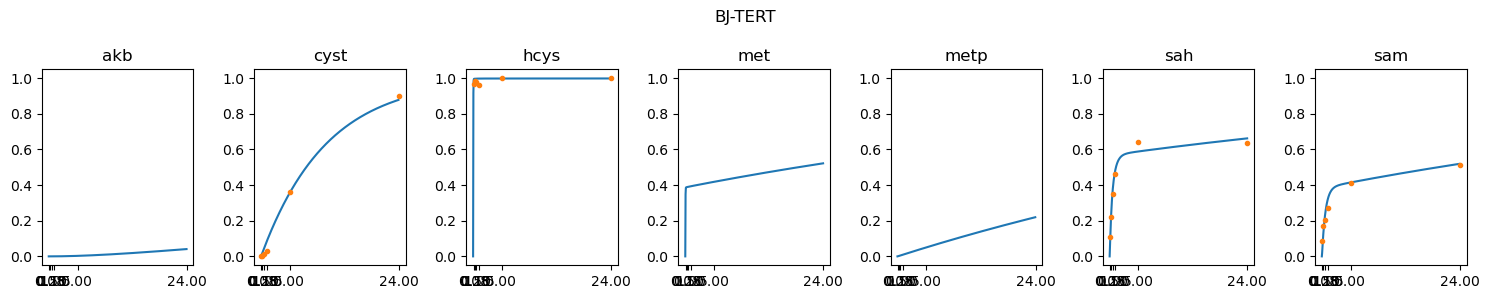

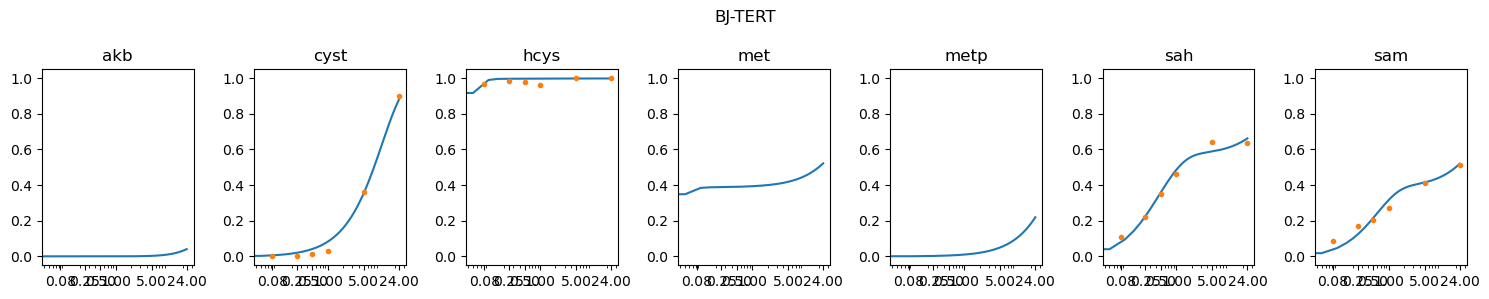

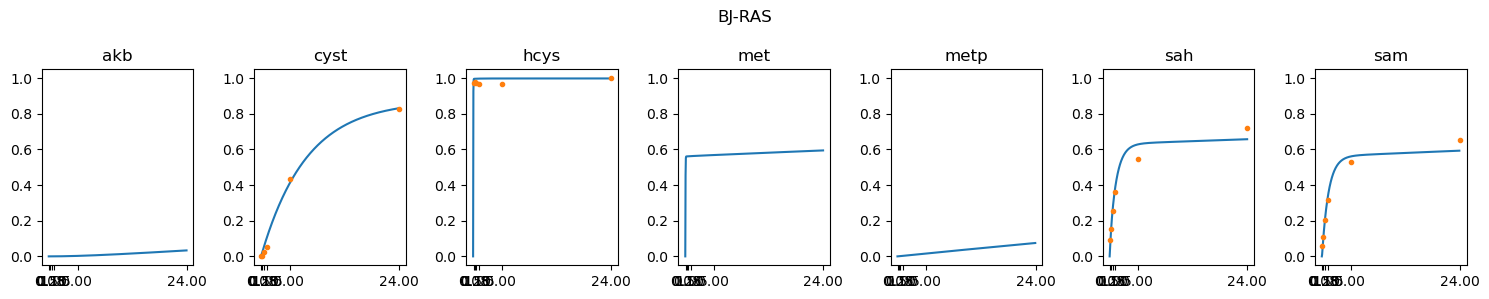

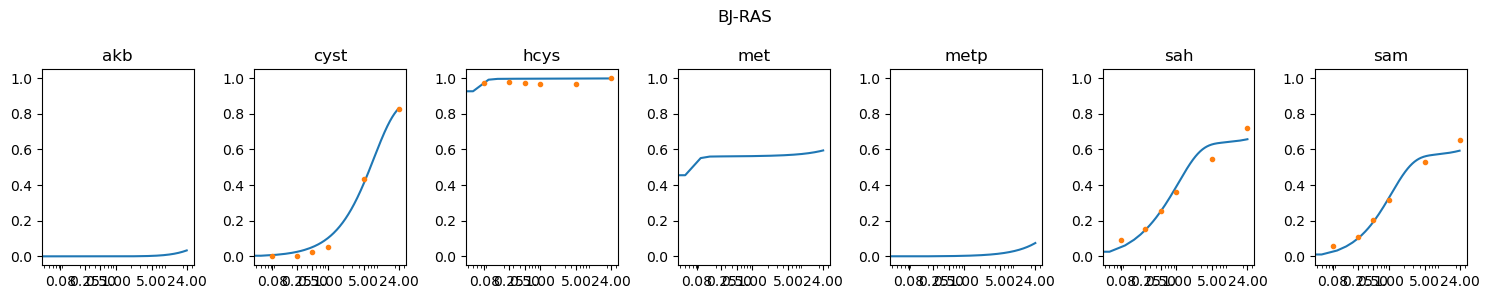

In [108]:
for cell_type in cell_types:
    for use_log_scale in [False, True]:
        plot_model_fit(
            flux_model, x_simulated.loc[cell_type], heavy_fraction_mean.loc[cell_type],
            use_log_scale=use_log_scale
        )
        plt.suptitle(cell_type)
        plt.tight_layout()
        plt.savefig(results_path / plot_file_name(cell_type, use_log_scale))

### Confidence intervals on estimated net fluxes
These are two-sided linearized confidence intervals, based on the parameter covariance from lmfit

In [105]:
ci_reactions = ['CYSTS', 'HCYS_IN', 'METS', 'MET_OUT', 'PROT_OUT', 'SAM_METH']
ci_table = pd.concat(
    [
        prepend_index_level(
            confidence_intervals_table(model_fits[cell_type], ci_level=0.9).loc[ci_reactions],
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)
ci_table

net    std err  ci_half-width    ci_lower  \
cell_type reaction                                                     
BJ-TERT   CYSTS       3.013350   0.823059       1.353811    1.659539   
          HCYS_IN   254.622997  74.598396     122.703442  131.919554   
          METS      268.287738  74.797499     123.030938  145.256800   
          MET_OUT    14.734389   7.898692      12.992193    1.742196   
          PROT_OUT  236.875258  74.480287     122.509170  114.366088   
          SAM_METH   16.678091   5.474012       9.003948    7.674143   
BJ-RAS    CYSTS       2.116263   0.372936       0.613425    1.502838   
          HCYS_IN    64.682553  11.404015      18.757936   45.924617   
          METS       94.485209  15.597957      25.656357   68.828852   
          MET_OUT    10.272987   5.915539       9.730196    0.542791   
          PROT_OUT   52.293303   9.753617      16.043273   36.250030   
          SAM_METH   31.918919  10.587069      17.414179   14.504740   

                      ci_upper  
cell_type reaction              
BJ-TERT   CYSTS       4.367161  
          HCYS_IN   377.326439  
          METS      391.318675  
          MET_OUT    27.726582  
          PROT_OUT  359.384428  
          SAM_METH   25.682040  
BJ-RAS    CYSTS       2.729688  
          HCYS_IN    83.440489  
          METS      120.141566  
          MET_OUT    20.003183  
          PROT_OUT   68.336576  
          SAM_METH   49.333098

In [106]:
# since seaborn (strangely) does not support drawing error bars from specified values,
# we provide the (max, min) range as values and plot using median (midrange) and max/min for error bars
ci_table_for_seaborn = ci_table[['ci_lower', 'ci_upper']].melt(ignore_index=False).sort_index(ascending=[False, True]).reset_index()
ci_table_for_seaborn

,cell_type,reaction,variable,value
0,BJ-TERT,CYSTS,ci_lower,1.659539
1,BJ-TERT,CYSTS,ci_upper,4.367161
2,BJ-TERT,HCYS_IN,ci_lower,131.919554
3,BJ-TERT,HCYS_IN,ci_upper,377.326439
4,BJ-TERT,METS,ci_lower,145.256800
5,BJ-TERT,METS,ci_upper,391.318675
6,BJ-TERT,MET_OUT,ci_lower,1.742196
7,BJ-TERT,MET_OUT,ci_upper,27.726582
8,BJ-TERT,PROT_OUT,ci_lower,114.366088
9,BJ-TERT,PROT_OUT,ci_upper,359.384428


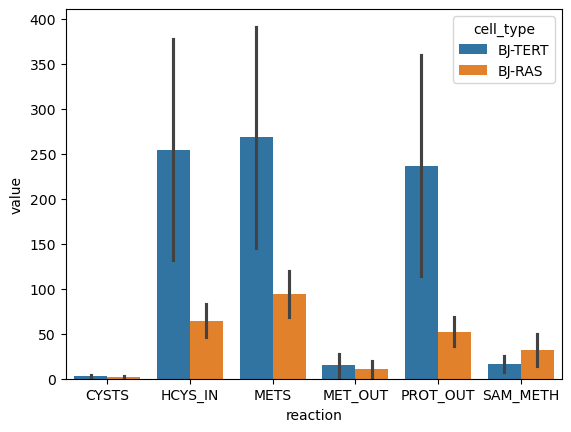

In [109]:
sns.barplot(
    ci_table_for_seaborn,
    x='reaction', y='value', hue='cell_type',
    estimator=np.median, errorbar=lambda x: [x.min(), x.max()]
)
plt.savefig(results_path / 'flux_ci.pdf')